## Load data

In [1]:
import numpy as np
import pandas as pd 

data_root = '/home/cathy/repos/kaggle-yelp/'

In [2]:
# businesses and their labels

def label_to_vec(x):
    """split input string and return a list of integers"""
    if x:
        return [int(i) for i in x.split(' ')]
    else:
        return []

train_biz_labels = pd.read_csv(data_root + 'train.csv', index_col = 0, dtype={'labels': str})
train_biz_labels.fillna('', inplace=True)
train_biz_labels['labels'] = train_biz_labels['labels'].apply(label_to_vec)
train_biz_labels.head()

,labels
business_id,
1000,"[1, 2, 3, 4, 5, 6, 7]"
1001,"[0, 1, 6, 8]"
100,"[1, 2, 4, 5, 6, 7]"
1006,"[1, 2, 4, 5, 6]"
1010,"[0, 6, 8]"


In [3]:
# fc6 and fc7 features
train_fc6 = pd.read_csv(data_root + 'fc6_means_per_business.csv', index_col = 0)
train_fc7 = pd.read_csv(data_root + 'fc7_means_per_business.csv', index_col = 0)
test_fc6 = pd.read_csv(data_root + 'fc6_means_per_business_test.csv', index_col = 0)
test_fc7 = pd.read_csv(data_root + 'fc7_means_per_business_test.csv', index_col = 0)

In [4]:
## concatenate train features
train_fc67 = pd.merge(train_fc6, train_fc7, left_index=True, right_index=True, 
                      sort=False, suffixes=('_f6', '_f7'))

In [5]:
## concatenate test features
test_fc67 = pd.merge(test_fc6, test_fc7, left_index=True, right_index=True, 
                      sort=False, suffixes=('_f6', '_f7'))

## Preprocess data

In [6]:
from sklearn import preprocessing

In [7]:
# Binarize business labels (one-hot-encoding)

mlb = preprocessing.MultiLabelBinarizer()
Y = mlb.fit_transform(train_biz_labels['labels'])

In [8]:
# Remove entries with no labels 

all_zero_idxs = np.all(Y==0, axis=1)
print("There are {0} businesses (rows) that are all zero".format(all_zero_idxs.sum()))

Y = Y[~all_zero_idxs]
train_fc67 = train_fc67.iloc[~all_zero_idxs]

print(Y.shape)
print(train_fc67.shape)

There are 4 businesses (rows) that are all zero
(1996, 9)
(1996, 8192)


## Split into training and validation set

In [9]:
from sklearn.cross_validation import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(train_fc67, Y, test_size=.2, random_state=421)

## Train linear and gaussian SVM
Fit one classifier per label, i.e. binary relevance or one-vs-all.

In [10]:
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

import time

In [11]:
# linear svm, l2 penalty, squared hinge loss

model_linear = svm.LinearSVC(penalty='l2', loss='squared_hinge')
classifier_linear = OneVsRestClassifier(model_linear)

tic = time.time()
classifier_linear.fit(X_train, Y_train)
toc = time.time()
print('computed in {}s'.format(toc-tic))

computed in 149.48450779914856s


In [12]:
# prediction on validation set
Y_pred_linear = classifier_linear.predict(X_val)

In [13]:
# rbf kernel svm
# default params:
# kernel = 'rbf'; C=1.0; gamma='auto', i.e. 1/n_features

model_rbf = svm.SVC(kernel='rbf')
classifier_rbf = OneVsRestClassifier(model_rbf)

tic = time.time()
classifier_rbf.fit(X_train, Y_train)
toc = time.time()
print('computed in {}s'.format(toc-tic))

computed in 121.83513855934143s


In [14]:
# prediction on validation set
Y_pred_rbf = classifier_rbf.predict(X_val)

In [15]:
print("Samples of predicted labels (in indicator matrix):\n", Y_pred_linear[0:3])
print("\nSamples of predicted labels:\n", mlb.inverse_transform(Y_pred_linear[0:3]))

Samples of predicted labels (in indicator matrix):
 [[0 0 0 0 0 0 0 0 1]
 [1 0 0 1 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 1]]

Samples of predicted labels:
 [(8,), (0, 3, 8), (0, 8)]


In [16]:
## this Kaggle competition uses example-based F measure, i.e. calculate the F1 score per instance, then average
## over all instances.  This corresponds to setting average='samples' in sklearn.metrics.f1_score(...)
def print_f1_metrics(test, pred):
    print("F1 score: ", f1_score(test, pred, average='samples'))
    print("Individual Class F1 score: ", f1_score(test, pred, average=None), '\n')

In [17]:
print('linear svm:\n')
print_f1_metrics(Y_val, Y_pred_linear)
print('rbf kernel svm:\n')
print_f1_metrics(Y_val, Y_pred_rbf)

linear svm:

F1 score:  0.774288822289
Individual Class F1 score:  [ 0.65        0.79197995  0.87238979  0.59459459  0.75806452  0.86434109
  0.92717584  0.72727273  0.87124464] 

rbf kernel svm:

F1 score:  0.820985791986
Individual Class F1 score:  [ 0.73251029  0.8556962   0.88470588  0.64851485  0.78661088  0.90410959
  0.95035461  0.77419355  0.88185654] 



## Plot SVM predicted vs real labels in t-SNE representation of validation set

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
#############################  Yelp Attributes #############################
#0: good_for_lunch                    5: has_alcohol
#1: good_for_dinner                   6: has_table_service  
#2: takes_reservations                7: ambience_is_classy
#3: outdoor_seating                   8: good_for_kids
#4: restaurant_is_expensive
############################################################################
attributes = ['good for lunch', 'good for dinner', 'takes reservations', 'outdoor seating',
              'restaurant is expensive', 'has alcohol', 'has table service', 'ambience is classy', 
              'good for kids']
yelp_dict = dict(enumerate(attributes))

In [20]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

X_reduced = TruncatedSVD(n_components=50, random_state=42).fit_transform(X_val)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_val)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 16.681192
[t-SNE] Iteration 25: error = 0.9814547, gradient norm = 0.0182733
[t-SNE] Iteration 50: error = 1.0228140, gradient norm = 0.0170243
[t-SNE] Iteration 75: error = 0.8817764, gradient norm = 0.0150908
[t-SNE] Iteration 100: error = 0.9725042, gradient norm = 0.0143501
[t-SNE] Error after 100 iterations with early exaggeration: 0.972504
[t-SNE] Iteration 125: error = 0.8674991, gradient norm = 0.0129715
[t-SNE] Iteration 150: error = 0.9304310, gradient norm = 0.0132604
[t-SNE] Iteration 175: error = 0.9817504, gradient norm = 0.0121795
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 0.981750


In [21]:
# plot t-SNE for validation set, including predictions by svm
# false positives - red circles
# false negatives - blue circles
# filled points - real classes
def plot_tSNE_validation_predictions(Y_pred, Y_val, X_embedded, maintitle):
    """
    INPUT:
    Y_pred - 2-d numpy array of predictions on validation set
    Y_val - 2-d numpy array of (actual) labels of validation set
    maintitle - string, title over all subplots
    X_embedded - 2-d numpy array of t-SNE features
    """
    n_classes = len(yelp_dict)
    plt.rcParams['figure.figsize'] = (10.0, 30.0)
    
    fig = plt.figure()
    fig.suptitle(maintitle, fontsize=20, y=1.01)
    
    for cl in range(n_classes):
        # false positive
        false_pos = np.where(Y_pred[:, cl] & ~Y_val[:,cl])
        # false negative
        false_neg = np.where(~Y_pred[:, cl] & Y_val[:,cl])
    
        plt.subplot(n_classes, 2, cl+1)
        plt.scatter(X_embedded[:,0], X_embedded[:,1], 
                    c=Y_val[:,cl], s=60, edgecolors='none')
        plt.scatter(X_embedded[false_pos,0], X_embedded[false_pos,1], 
                    facecolor='none', s=120, linewidths=2, edgecolors='r')
        plt.scatter(X_embedded[false_neg,0], X_embedded[false_neg,1], 
                    facecolor='none', s=120, linewidths=2, edgecolors='b')
    
        min_x = np.min(X_embedded[:, 0])
        max_x = np.max(X_embedded[:, 0])
        min_y = np.min(X_embedded[:, 1])
        max_y = np.max(X_embedded[:, 1])
        plt.xlim(min_x - 3, max_x + 3 )
        plt.ylim(min_y - 3, max_y + 3 )
    
        plt.title(yelp_dict[cl])
    
    plt.tight_layout()

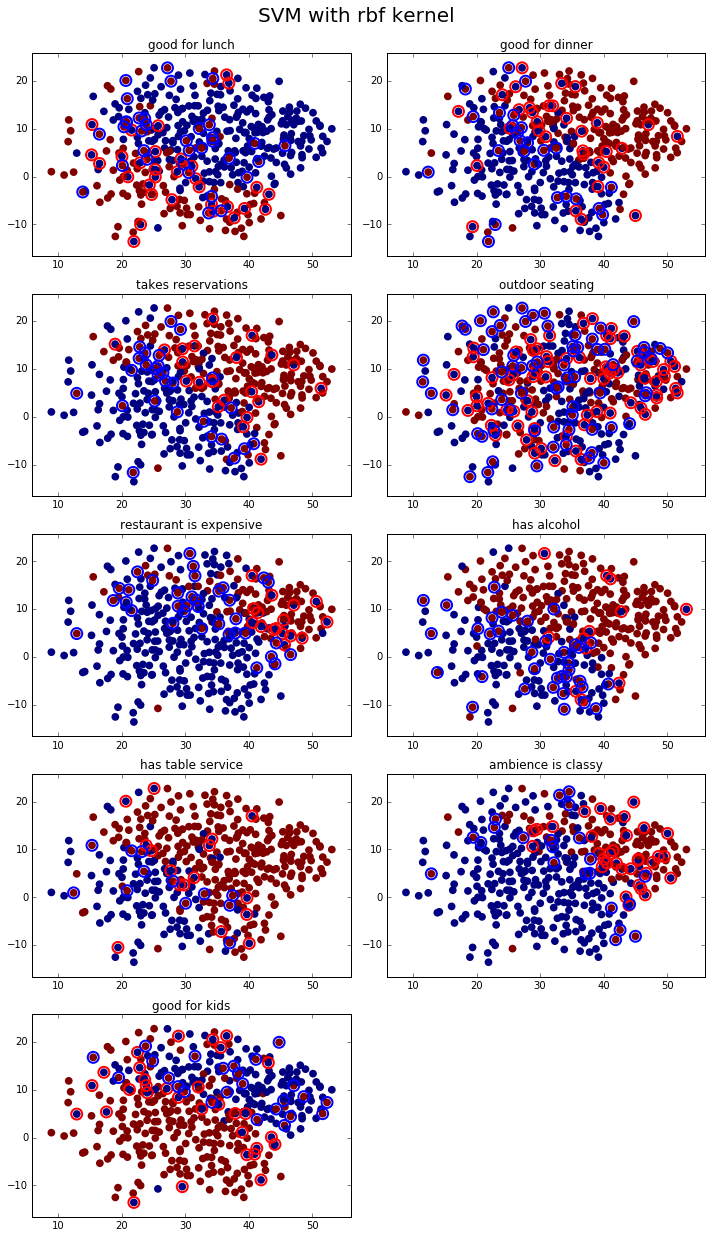

In [22]:
plot_tSNE_validation_predictions(Y_pred_rbf, Y_val, X_embedded,"SVM with rbf kernel")

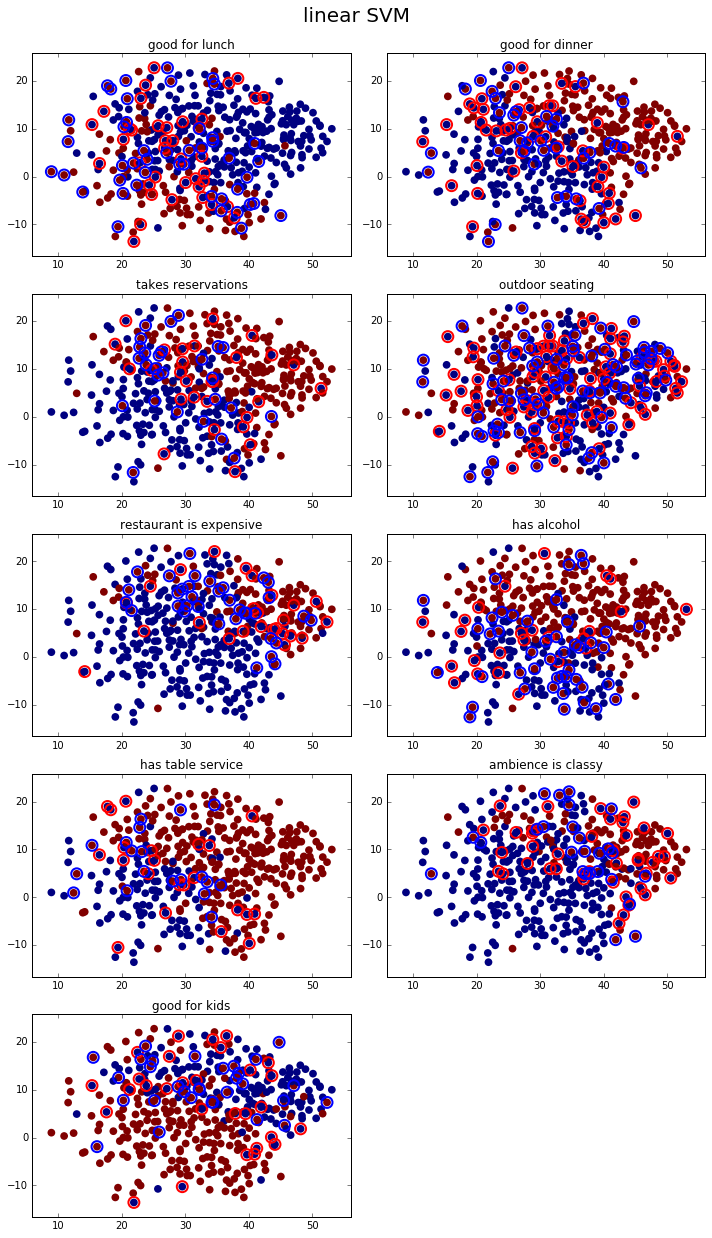

In [23]:
plot_tSNE_validation_predictions(Y_pred_linear, Y_val, X_embedded, "linear SVM")

## Optimize rbf parameters using validation set (20% of the training set)

In [24]:
# tuning parameters for svm.SVC
print(svm.SVC().get_params().keys())

dict_keys(['class_weight', 'verbose', 'max_iter', 'cache_size', 'gamma', 'random_state', 'tol', 'coef0', 'kernel', 'shrinking', 'degree', 'decision_function_shape', 'C', 'probability'])


In [25]:
def cross_validate(X_train, X_val, Y_train, Y_val):
    """
    Perform cross-validation of rbf SVM
    INPUT:
    X_train, X_val - 2-d arrays of features
    Y_train, Y_val - 2-d array of binary labels (binarized multi-label)
    
    OUTPUT:
    clf_best - best rbf classifier, selected by performance on validation set
    """
    
    #C_range = np.logspace(-1, 1, 3)
    #gamma_range = np.logspace(-4, -1, 4)
    C_range = np.linspace(1.5, 3, 6)
    gamma_range = [0.0002, 'auto', 0.00005]
    
    f1_best = 0
    for C in C_range:
        for gamma in gamma_range:
            print("C: {0}, gamma: {1}".format(C, gamma))
            model_rbf = svm.SVC(kernel='rbf', C=C, gamma=gamma)
            classifier_rbf = OneVsRestClassifier(model_rbf)
            classifier_rbf.fit(X_train, Y_train)
            Y_pred_rbf = classifier_rbf.predict(X_val)
            
            f1_sampleavg = f1_score(Y_val, Y_pred_rbf, average='samples')
            f1_individual = f1_score(Y_val, Y_pred_rbf, average=None)
            print("F1 score: {}".format(f1_sampleavg))
            print("Individual class F1 score: {}\n".format(f1_individual))
            
            if f1_sampleavg > f1_best:
                C_best = C
                gamma_best = gamma
                clf_best = classifier_rbf
                f1_best = f1_sampleavg

    print("The best parameters are C={0}, gamma={1} with a score of {2}\n".format(C_best, gamma_best, f1_best))
    
    return clf_best

In [26]:
tic = time.time()
best_clf = cross_validate(X_train, X_val, Y_train, Y_val)
toc = time.time()
print('computed in {}s'.format(toc-tic))

C: 1.5, gamma: 0.0002
F1 score: 0.8210934343434343
Individual class F1 score: [ 0.74493927  0.86294416  0.8852459   0.63840399  0.77824268  0.90019569
  0.95559503  0.768       0.88322718]

C: 1.5, gamma: auto
F1 score: 0.821110680985681
Individual class F1 score: [ 0.73251029  0.85353535  0.88785047  0.64339152  0.7966805   0.90410959
  0.95390071  0.76190476  0.88421053]

C: 1.5, gamma: 5e-05
F1 score: 0.8165548063048064
Individual class F1 score: [ 0.725       0.84711779  0.88056206  0.65533981  0.77824268  0.90410959
  0.94699647  0.76422764  0.88322718]

C: 1.8, gamma: 0.0002
F1 score: 0.821535839160839
Individual class F1 score: [ 0.7398374   0.86075949  0.8852459   0.64339152  0.78333333  0.90019569
  0.95559503  0.76984127  0.88322718]

C: 1.8, gamma: auto
F1 score: 0.8215078255078255
Individual class F1 score: [ 0.73469388  0.86005089  0.88785047  0.64339152  0.78333333  0.90234375
  0.95390071  0.76377953  0.88794926]

C: 1.8, gamma: 5e-05
F1 score: 0.8173463064713065
Individ

/home/cathy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/cathy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)



Individual class F1 score: [ 0.7295082   0.86363636  0.8951049   0.65686275  0.79835391  0.90448343
  0.95390071  0.75889328  0.8893617 ]

C: 2.4, gamma: 5e-05
F1 score: 0.8161911838161838
Individual class F1 score: [ 0.73333333  0.84577114  0.88578089  0.65036675  0.79338843  0.90588235
  0.95053004  0.75502008  0.87898089]

C: 2.7, gamma: 0.0002
F1 score: 0.8228437395937395
Individual class F1 score: [ 0.76190476  0.85929648  0.8852459   0.62278481  0.79166667  0.89236791
  0.95744681  0.76984127  0.89596603]

C: 2.7, gamma: auto
F1 score: 0.82545516983017
Individual class F1 score: [ 0.73251029  0.86146096  0.8951049   0.65024631  0.79835391  0.90448343
  0.95575221  0.76078431  0.8893617 ]

C: 2.7, gamma: 5e-05
F1 score: 0.8181358086358087
Individual class F1 score: [ 0.74897119  0.85        0.88578089  0.64373464  0.80658436  0.90802348
  0.94867257  0.75697211  0.87711864]

C: 3.0, gamma: 0.0002
F1 score: 0.8202245115995116

/home/cathy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/cathy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)



Individual class F1 score: [ 0.75        0.85929648  0.88262911  0.61809045  0.79338843  0.89236791
  0.95559503  0.76984127  0.89787234]

C: 3.0, gamma: auto
F1 score: 0.8228499833499835
Individual class F1 score: [ 0.74285714  0.85929648  0.8951049   0.64691358  0.80165289  0.90234375
  0.9540636   0.7578125   0.891258  ]

C: 3.0, gamma: 5e-05
F1 score: 0.8180407231657232
Individual class F1 score: [ 0.73553719  0.85        0.88837209  0.64547677  0.81147541  0.90802348
  0.95053004  0.74900398  0.87898089]

The best parameters are C=2.4, gamma=0.0002 with a score of 0.8257169080919081

computed in 2707.0657727718353s


/home/cathy/miniconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [27]:
## make predictions on test set using best model C=2.4, gamma=auto=1/n_features
test_pred = best_clf.predict(test_fc67)

In [28]:
# convert labels to original format

test_pred_list = mlb.inverse_transform(test_pred)

def tuple_to_string(x):
    return ' '.join(map(str, x))

test_pred_strings = list(map(tuple_to_string, test_pred_list))

In [29]:
## write to csv
test_df = pd.DataFrame({'business_id': test_fc67.index,
                        'labels': test_pred_strings})
test_df.to_csv(data_root + 'test_predictions_svm_rbf.csv', index=False)

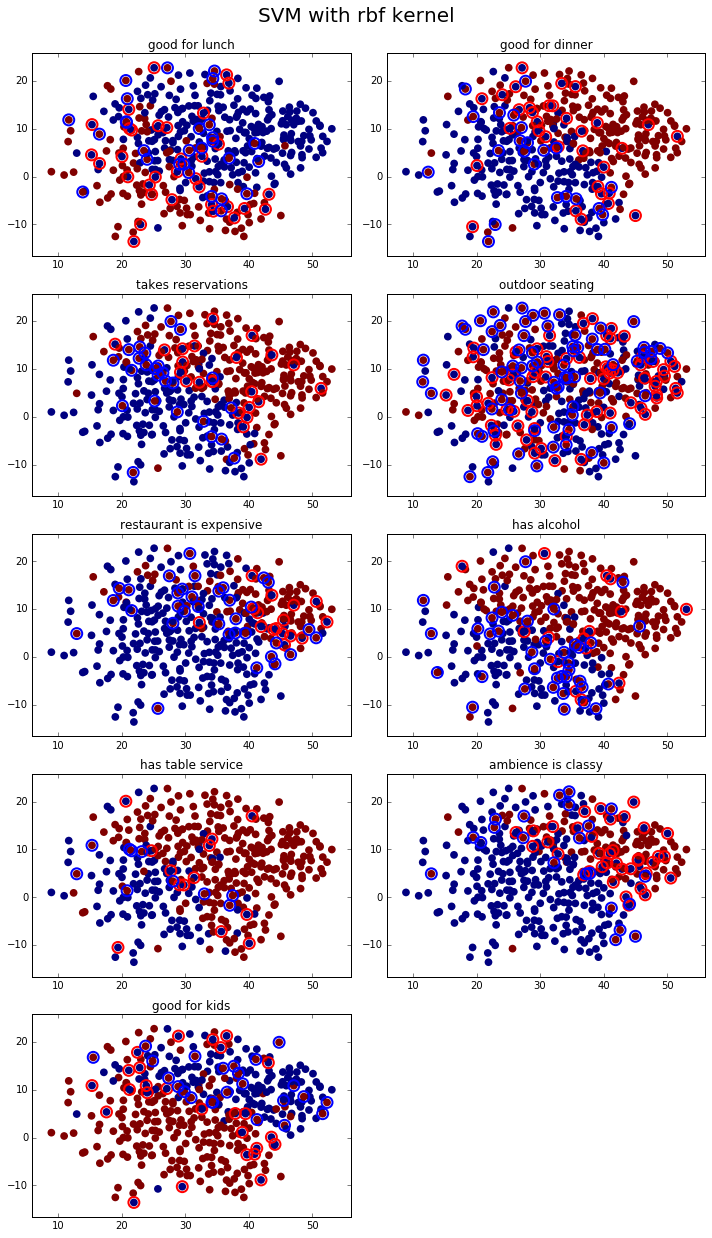

In [31]:
## visualize performance of best model in t-SNE
Y_pred_best = best_clf.predict(X_val)
plot_tSNE_validation_predictions(Y_pred_best, Y_val, X_embedded,"SVM with rbf kernel")